# Milestone 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

We start by loading the tables.

In [ ]:
df_plot = pd.read_csv("data/MovieSummaries/plot_summaries.txt", sep='\t', header=None, names=["wikiID", "plot"])

df_meta = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", sep='\t', header=None, 
    names=["wikiID", "freeID", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"])

df_char = pd.read_csv("data/MovieSummaries/character.metadata.tsv", sep='\t',header=None, 
    names=["WikiID", "freeID", "release_date", "char_name", "actor_DOB", "actor_gender", "actor_height", "actor_ethnicity",
           "actor_name", "Actor_age", "freeID_char_map", "FreeID_char", "FreeID_actor"])

df_char_names = pd.read_csv('data/MovieSummaries/name.clusters.txt', sep="\t", header=None, 
    names=["char_name", "freeID_char_map"])

df_tropes = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=["trope", "details"])

## Data features and missing values

In [ ]:
df_plot.head()

In [ ]:
df_plot.info()

In [ ]:
df_meta.head()

In [ ]:
df_meta.info()

Looking at the output above, we might think that the languages, countries and genres columns have no missing elements but actually some elements are just empty dictionary values

In [ ]:
print(df_meta['languages'].value_counts()['{}'])
print(df_meta['countries'].value_counts()['{}'])
print(df_meta['genres'].value_counts()['{}'])

In [ ]:
df_char.head()

In [ ]:
df_char.info()

In [ ]:
df_char_names.head()

In [ ]:
df_char_names.info()

In [ ]:
df_tropes.head()

In [ ]:
df_tropes = df_tropes.drop(["details"], axis=1).join(pd.json_normalize(df_tropes["details"].map(json.loads).tolist())).rename(
    columns={"id":"freeID_char_map"})

df_tropes.head()

In [ ]:
df_tropes.info()

---
## NLPCore

After we looked at the Stanford CoreNLP-processed summaries, we decided it would not be useful for us.

The code below shows how to treat these data.

In [ ]:
import gzip
import os
from bs4 import BeautifulSoup

path = "data/corenlp_plot_summaries/"
files = os.listdir(path)
print(files[0])
f = gzip.open(path+files[0], 'rb')

test = f.read().decode()
# print(test)

Bs_data = BeautifulSoup(test, "xml")
print(Bs_data.find("sentence", {'id':'20'}).find('NER').text)

---
## Exploratory data analysis

### Genres, languages and countries

In [ ]:
def fcount(df):
    df2 = pd.DataFrame(data={
        'id': df.apply(lambda x: list(json.loads(x).keys())),
        'name': df.apply(lambda x: list(json.loads(x).values()))
    })
    
    distinctf = []
    counter = []

    for i in range(df2.shape[0]):
        fid = df2["id"].iloc[i]
        fname = df2["name"].iloc[i]
        for j in range(len(fid)):
            if [fid[j], fname[j]] not in distinctf:
                distinctf.append([fid[j], fname[j]])
                counter.append(1)
            else:
                counter[distinctf.index([fid[j], fname[j]])] += 1

    new = pd.DataFrame(data={
        'id': [s[0] for s in distinctf],
        'name': [s[1] for s in distinctf],
        'count': counter
    })
    
    return new.sort_values(by="count", ascending=False, ignore_index=True)

In [ ]:
df_genre = fcount(df_meta["genres"])
df_genre.head(20)

In [ ]:
df_lang = fcount(df_meta["languages"])
df_lang.head(20)

In [ ]:
df_country = fcount(df_meta["countries"])
df_country.head(20)

### Release date distribution

In [ ]:
print(df_meta['release_date'].dt.year.max())

In [ ]:
df_meta['release_date'] = pd.to_datetime(df_meta['release_date'], errors = 'coerce')
df_meta.groupby(df_meta["release_date"].dt.year).count()['wikiID'].plot()
plt.show()

### Runtime distribution

In [ ]:
print(df_meta['runtime'].max())

2 years of runtime?

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_meta[df_meta['runtime'] < 400]['runtime'], bins=400)
ax.set_title('Distribution of runtime')

plt.show()

### Runtime distribution

In [ ]:
df_meta['revenue'].dropna().hist(bins=100)

In [ ]:
print(df_meta['revenue'].max())

In [ ]:
print(df_meta[df_meta['revenue']==df_meta['revenue'].max()].name)

There is a very large different between most of the movies and the movies that had a huge success such as "Avatar".

### Distribution of number of words in plot description

In [ ]:
#use raw plot_summaries and count nb of words in each plot 
df_plot_fltr = df_plot.copy()
df_plot_fltr['nb_words'] = df_plot_fltr['plot'].apply(lambda n: len(n.split()))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_fltr['nb_words'], bins=1000)
ax.set_title('Distribution of number of words per plot description')

plt.show()

Only keep the plots with less than 2000 words (which interval?)

In [ ]:
threshold = 2000
df_plot_fltr = df_plot_fltr.loc[df_plot_fltr['nb_words'] < threshold]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_plot_fltr['nb_words'], bins=1000)
ax.set_title('Distribution of number of words per plot description')


plt.show()

What would be the minimum number of words to find senseful topic extraction?  
* characters by film distribition: how many characters have been labelised for each film?

In [ ]:
df_char_fltr = df_char[['freeID','FreeID_actor']].copy()
df_char_fltr = df_char_fltr.groupby(['freeID']).size().reset_index(name='counts')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_char_fltr['counts'], bins=120)
ax.set_title('Distribution of number of characters labelised per film')

plt.show()

In [ ]:
red_square = dict(markerfacecolor='r', marker='s')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(df_char_fltr['counts'], vert=False, flierprops=red_square)
ax.set_title('Number of characters labelised per film')
plt.show()

In [ ]:
print("1rst quartile, median and 3rd quartile values: ")
print(df_char_fltr['counts'].quantile([0.25,0.5,0.75]))

"Hemingway & Gellhorn" has more than 115 characters labelised! 

In [ ]:
df_char_fltr.loc[df_char_fltr['counts'] > 100].head(10)

## Join the dataframes

The feature connecting dataframes together is the Wikipedia ID. Also there are more metadatas of movies (81741 movies) than plots (42303 movies). We will only keep the metadatas of the movies we know the plot of.

In [ ]:
df_full = df_meta.merge(df_plot, how='inner', on="wikiID")
df_full.head()

Only a small fraction of the characters have been labellised with a trope (500), compared to the number of unlabeled (450669). Here is the dataframe containing the characters with trope

In [ ]:
df_inner_char = df_char.merge(df_tropes, how='inner', on='freeID_char_map')

df_inner_char.drop(columns=["char", "actor"], inplace=True)
df_inner_char.head()

---
## Preprocessing

Preprocessing of metadata dataset : remove films without country, language, genre, runtime, release_date. 
Also remove films with less than nb_min_actors (=1) labeled actors.  

In [ ]:
nb_min_actors = 1
# Remove NaNs
# df_char_noNaN = df_char.loc[df_char['char_name'].isna() | (df_char['actor_name'].isna())]
df_char_ = df_char.dropna(subset=['char_name', 'actor_name'])
# Group by movies the nb of actors labelised by movie
df_char_count = df_char_.groupby(['freeID']).size().reset_index(name='actor count')
# Remove the films with less than nb_min_actors
df_char_clean = df_char_count.loc[df_char_count['actor count'] >= nb_min_actors]

print('number of movies remaining after character dataset preprocessing: ', df_char_clean.shape[0])

In [ ]:
df_inner_meta = df_meta.merge(df_char_clean, how='inner', on='freeID')

df_clean = df_inner_meta.loc[(df_inner_meta['countries'] != '{}') & (df_inner_meta['languages'] != '{}') & 
                             (df_inner_meta['genres'] != '{}') & df_inner_meta['release_date'].notnull()].reset_index()

print('number of movies remaining after movie metadata preprocessing: ', df_clean.shape[0])

In [ ]:
df_clean = df_clean.merge(df_plot, how='inner', on='wikiID')

print('number of movies remaining after movie metadata preprocessing: ', df_clean.shape[0])

In [ ]:
df_clean.info()

By observing the non-null counts, on the runtime and revenue columns, we decided to eliminate these attributes. 

In [ ]:
# df_clean.drop(columns=['revenue','runtime','index'], inplace=True)
df_clean.drop(columns=['revenue','index'], inplace=True)

Right formatting for next data analysis steps:

In [ ]:
df_clean['countries'] = pd.DataFrame(data={'countries': df_clean['countries'].apply(lambda x: list(json.loads(x).values()))})
df_clean['languages'] = pd.DataFrame(data={'languages': df_clean['languages'].apply(lambda x: list(json.loads(x).values()))})
df_clean['genres'] = pd.DataFrame(data={'genres': df_clean['genres'].apply(lambda x: list(json.loads(x).values()))})    

Preprocessed dataset:

In [ ]:
df_clean.info()

Every columns has the same number of non-null values, and there isn't any null value inside of it. 

---
## Scrapping

In [ ]:
import requests
from bs4 import BeautifulSoup
import pywikibot


def scrapping(wiki_ID):
    list = []

    query_base = "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query="

    wiki_ID_encoded = wiki_ID.replace("/","%2F")

    pre_str = "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22"
    post_str = "%22%20%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D"

    query = pre_str + wiki_ID_encoded + post_str

    response = requests.get(query)
    soup = BeautifulSoup(response.content, "html.parser")

    results = soup.find(id="results")

    try:
        entity_wiki_id = response.json()['results']['bindings'][0]['s']['value']
    except:
        print("Scrapping failed")
        return [None,None,None,None,None]
        

    entity_wiki_id = response.json()['results']['bindings'][0]['s']['value']

    str = entity_wiki_id.split('/')
    entity = str[-1]
    print(entity)
    site = pywikibot.Site("wikidata", "wikidata")
    repo = site.data_repository()
    item = pywikibot.ItemPage(repo, entity)
    item_dict = item.get()
    clm_dict = item_dict["claims"] # Get the claim dictionary

    #P57 for a movie director
    try:
        clm_list = clm_dict["P57"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    #P86 for a composer
    try:
        clm_list = clm_dict["P86"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    #P840 for the narrative location
    try:
        clm_list = clm_dict["P840"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    #P344 for the photographer
    try:
        clm_list = clm_dict["P344"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    #P462 for the color
    try:
        clm_list = clm_dict["P462"]
        for clm in clm_list:
                ...
                clm_trgt = clm.getTarget()
        list.append(clm_trgt.labels['en'])
    except:
        list.append(None)

    print('scraped sucessfuly')
    return list

In [ ]:
sub_df = df_clean.iloc[0:15000]

list2 = [[]]
for index, row in sub_df.iterrows():
    list2.append(scrapping(row['freeID']))

---
## Choice of attributes based on data exploratory analysis

attributs scraped:
- Director 
- Color
 
enlever attribut du dataset final:
- Revenu 

filtré?
- Title
- Plot existant + taille plot
- Genre

non filtré? 
- Runtime:  remplacer valeur abérente par NaN mais pas filtré
- Release date: remplacer valeur abérente par NaN mais pas filtré
- Revenu
- Language
- Country
- Actors
- Characters
- Director
- Color

retenu pour similarité? 
- Plot
- Title
- Runtime: long metrage/court metrage qui remplace run time
- Release date: year
- Country (petit poids)
- Language (petit poids)
- Actors
- Characters
- Genres
- Director
- Color (petit poids)

pas retenu pour similarité? 
- Revenu

### 1. Algorithm to study similarity between movies attributes

In [ ]:
import math
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import gensim

#### Jaccard similarity implementation
**Method**
The jaccard similarity is more appropriate to compute similarities between datasets of categorical attributes where we want to see if these datasets have some attributes in common or not, and how many they are.

**Implementation**
`jaccard_similarity` function written here below. Since we compare to what extent different movies attributes contain the exact same words, we may need to add a lemmatizer for example to take care of same words being in the singular or plural form, or having uppercase or lowercase initial letter.

**Movie Attribute similarity that can be studied**
- Movie genre
- Movie Language 
- Movie Country
- Actors
- Characters
- Director

Here we can use this method for these attributes because we want to find which of those attributes contain the exact same words and study the similarity based on this analysis. 

In [63]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  if union_cardinality == 0:
    return 0.0
  else:
    return intersection_cardinality/float(union_cardinality)

list1 = ['Drama', 'Mystery', 'Fantasy', 'Adventure']
list2 = ['Fantasy Adventure', 'Adventure', 'Epic', 'Fantasy', 'Drama', 'Action', 'Sword and sorcery films']
list3= ['Satire', 'Comedy', 'Family film']
list4= ['Musical', 'Drama', 'Comedy']
list5= ['Romantic comedy', 'Romance Film', 'Comedy']
list6= ['Comedy']
list7=[]
list8= ['Action']
list9=[]

print("Example of similarities computed with jaccard similarity for the attribute -Movie genre- :")
print("Between lists 1 and 2:", jaccard_similarity(list1, list2))
print("Between lists 3 and 4:",jaccard_similarity(list3, list4))
print("Between lists 5 and 6:",jaccard_similarity(list5, list6))
print("Between lists 3 and 6:",jaccard_similarity(list3, list6))
print("Between lists 3 and 7:",jaccard_similarity(list3, list7))
print("Between lists 2 and 8:",jaccard_similarity(list2, list8))
print("Between lists 7 and 9:",jaccard_similarity(list7, list9))
print("Between lists 6 and 8:",jaccard_similarity(list6, list8))
print("Between lists 8 and 8:",jaccard_similarity(list8, list8))

Example of similarities computed with jaccard similarity for the attribute -Movie genre- :
Between lists 1 and 2: 0.375
Between lists 3 and 4: 0.2
Between lists 5 and 6: 0.3333333333333333
Between lists 3 and 6: 0.3333333333333333
Between lists 3 and 7: 0.0
Between lists 2 and 8: 0.14285714285714285
Between lists 7 and 9: 0.0
Between lists 6 and 8: 0.0
Between lists 8 and 8: 1.0


#### Similarity between binary attributes
**Method**

We have a unique discrete attribute that can take the values: $\left\{1, 0, \text{Nan} \right\}$, where NaN is the case where we don't have information about this attribute.  

**Implementation**

The similarity here is simply 1 if both attributes are equal to 1 or both equal to 0. If at least one of the two attributes is Nan then the similarity is 0.

**Movie Attribute similarity that can be studied**

- Color (1: Movie in colours, 0: Movie in black and white, NaN)
- Runtime (1: full-length film, 0: short film, NaN)

#### Similarity between positive integers attributes
**Method**
We want compute the similiarity between two one-dimension continuous variables that belong to $\mathbb{N}$. 

**Implementation**
We start by computing the distance between the two positive integer by computing the manhattan distance: 
$$
d(A,B)=|A-B|
$$
We want to normalize this distance so that $d \in [0,1]$. We do a Min-Max normalization that performs a linear transformation on the original data. This technique gets all the scaled data in the range $[0,1]$. This allows to preserve the relationships among the original data values. The formula to achieve this is the following:
$$
d_{scaled}=\frac{d-d_{min}}{d_{max}-d_{min}}
$$
The cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers.
We can finally compute the similarity based on this distance:
$$
S=1-d_{scaled}
$$
where $S \in [0,1]$.

**Movie Attribute similarity that can be studied**
- Release year

#### tf-idf : Term frequency-inverse document frequency
**Term frequency and Inverse document frequency**

$$
tf(t,d)=\frac{f_{t,d}}{ \sum_{t' \in d} f_{t',d} } \quad \textrm{and} \quad idf(t,D)=log(\frac{N}{|d\in D:t\in d|})
$$
where $f_{t,d}$ = raw frequency = number of times a term $t$ occurs in document $d$, $ \sum_{t' \in d} f_{t',d}$=total number of terms $t'$ in $d$ by suming each independent occurrence
<br>
where $N$=$|D|$= number of documents in corpus $D$, $|d\in D:t\in d|$= number of documents where t appears (where $tf(t,d)\neq 0$)

To prevent bias towards longer documents, the term frequency can be computed as follow:
$$
tf(t,d)=0.5+0.5\frac{f_{t,d}}{max(f_{t',d}:t'\in d)}
$$
To avoid divinding by zero, the idf denominator can ba adjusted as follow:
$$
idf(t,D)=log(\frac{N}{1+|d\in D:t\in d|})
$$
**Term frequency-inverse document frequency**

From the term frequency and the inverse document frequency we can compute the tf-idf:
$$
tf-idf(t,D)=tf(t,d) \cdot idf(t,D)
$$

The tf-idf reflects how important a word is to a document in corpus. tf-idf increase proportionally with the number of times a word appear in a document, but it is offset by the number of documents in the corpus that contains the word. It is high when there is high term frequency in document d **and** low document frequency of the term in the whole corpus. This helps to adjust the fact that some words appear more frequently that we can define as common terms. It tends to filter out those common words.

**Implementation**

tfidf can be implemented using the `sklearn` or `GenSim` opensource library. After obtaining tf-idf associated for each word in each text, we can associate to each text a vector composed of his words tf-idf and null values for other words.
Then we can compute the **cosine similarity** between those texts represented as vectors.

**Movie Attribute similarity that can be studied**
- Title

In [56]:
def dot(A,B): 
  return (sum(a*b for a,b in zip(A,B)))

def cosine_similarity(a,b):
  """ returns cosine similarity between two lists """
  return dot(a,b)/((dot(a,a)**.5)*(dot(b,b)**.5)) 

print("Example cosine similarity between vectors [1,0] and [1,1]: ", cosine_similarity([1,0],[1,1]))

Example cosine similarity between vectors [1,0] and [1,1]:  0.7071067811865475


Example cosine similarities between 8 movie titles: 
 [[1.         0.31737852 0.43014588 0.38513794 0.22205531 0.
  0.09331816 0.20685603]
 [0.31737852 1.         0.13648408 0.07465232 0.22333866 0.
  0.09385748 0.2563455 ]
 [0.43014588 0.13648408 1.         0.37161231 0.41268258 0.
  0.09004092 0.06449977]
 [0.38513794 0.07465232 0.37161231 1.         0.36264365 0.
  0.         0.24689427]
 [0.22205531 0.22333866 0.41268258 0.36264365 1.         0.33392025
  0.39195654 0.10554557]
 [0.         0.         0.         0.         0.33392025 1.
  0.25156386 0.        ]
 [0.09331816 0.09385748 0.09004092 0.         0.39195654 0.25156386
  1.         0.        ]
 [0.20685603 0.2563455  0.06449977 0.24689427 0.10554557 0.
  0.         1.        ]]


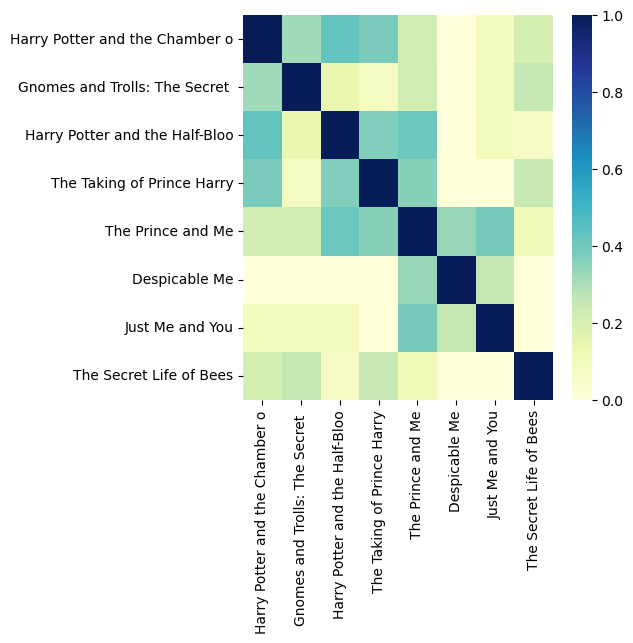

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

#list1= 'Drama Mystery Fantasy Adventure'
#list2= 'Fantasy Adventure  Adventure  Epic  Fantasy  Drama  Action Sword and sorcery'
#list3= 'Satire Comedy Family'
#list4= 'Musical Drama Comedy'
#list5= 'Romantic Comedy Romance Comedy'
#list6= 'Comedy'

list1= 'Harry Potter and the Chamber of Secrets'
list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
headlines = [list1,list2,list3,list4,list5,list6,list7,list8]

labels = [headline[:30] for headline in headlines] 
def create_heatmap(similarity, cmap = "YlGnBu"):
  df = pd.DataFrame(similarity)
  df.columns = labels
  df.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df, cmap=cmap)

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
X = vectorizer.fit_transform(headlines)
#print(vectorizer.get_feature_names())
list_vectors = X.toarray()
print("Example cosine similarities between 8 movie titles: \n",cosine_similarity(list_vectors))
create_heatmap(cosine_similarity(list_vectors))

#### GloVe algorithm
**Definition**
The `GloVe` algorithm is an opensource standford algorithm that associates similarity between words by obtaining vectors representations for words and by mapping them into a meaningful space.

**Implementation** 
We can apply soft cosine similarity computation to study similarity between texts. The matrix S from the soft cosine definition can be calculated with the library `GenSim` and using the `GloVe` algorithm. We would obtain a dataset containing a vector for all the words in our corpus and we could compute the matrix S associating a similarity matrix to all of these words. Then with the soft cosine similarity we could analyse the similarity between the documents in our corpus. 

**Movie Attribute similarity that can be studied**
- Title

In [59]:
from re import sub
from gensim.utils import simple_preprocess

query= 'Harry Potter and the Chamber of Secrets'

list2= 'Gnomes and Trolls: The Secret Chamber'
list3= 'Harry Potter and the Half-Blood Prince'
list4= 'The Taking of Prince Harry'
list5= 'The Prince and Me'
list6= 'Despicable Me'
list7= 'Just Me and You'
list8= 'The Secret Life of Bees'
documents = [list2,list3,list4,list5,list6,list7,list8]
stopwords = ['the', 'and', 'are', 'a']

# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
def preprocess(doc):
    # Tokenize, clean up input document string
    doc = sub(r'<img[^<>]+(>|$)', " image_token ", doc)
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    doc = sub(r'\[img_assist[^]]*?\]', " ", doc)
    doc = sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " url_token ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

# Preprocess the documents, including the query string
corpus = [preprocess(document) for document in documents]
query = preprocess(query)

In [60]:
import gensim.downloader as api
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

In [61]:
# Load the model: this is a big file, can take a while to download and open
glove = api.load("glove-wiki-gigaword-50")    
similarity_index = WordEmbeddingSimilarityIndex(glove)

# Build the term dictionary, TF-idf model
dictionary = Dictionary(corpus+[query])
tfidf = TfidfModel(dictionary=dictionary)

# Create the term similarity matrix.  
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)

100%|██████████| 18/18 [00:00<00:00, 97.30it/s]


In [62]:
# Compute Soft Cosine Measure between the query and the documents.
# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
query_tf = tfidf[dictionary.doc2bow(query)]

index = SoftCosineSimilarity(tfidf[[dictionary.doc2bow(document) for document in corpus]],similarity_matrix)

doc_similarity_scores = index[query_tf]

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(doc_similarity_scores)[::-1]
print("Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:")
for idx in sorted_indexes:
    print(f'{idx} \t {doc_similarity_scores[idx]:0.3f} \t {documents[idx]}')

Soft similarities computed between the title 'Harry Potter and the Chamber of Secrets' and the other titles:
1 	 0.622 	 Harry Potter and the Half-Blood Prince
2 	 0.580 	 The Taking of Prince Harry
0 	 0.550 	 Gnomes and Trolls: The Secret Chamber
6 	 0.370 	 The Secret Life of Bees
5 	 0.000 	 Just Me and You
4 	 0.000 	 Despicable Me
3 	 0.000 	 The Prince and Me


/Users/camilleguillaume/opt/anaconda3/envs/ada/lib/python3.9/site-packages/gensim/similarities/termsim.py:382: RuntimeWarning: divide by zero encountered in divide
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)
/Users/camilleguillaume/opt/anaconda3/envs/ada/lib/python3.9/site-packages/gensim/similarities/termsim.py:382: RuntimeWarning: invalid value encountered in multiply
  normalized_corpus = np.multiply(corpus, 1.0 / corpus_norm)


In [ ]:
from gensim.similarities import docsim
from docsim import DocSim
docsim = DocSim_threaded(verbose=True)
similarities = docsim.similarity_query(query_string, documents)

### 2. Topic extraction method
To compare plots, we will use a topic extraction algorithm. There are a lot that exist, but we will concentrate on three possible: LDA, Doc2Vec and BERTopic.

#### Preprocessing method on a document corpus before topic extraction

Here is a preprocessing approach that can be implemented before using a topic extraction analysis
1. Removing the stop words from the documents which are the most common words occuring in texts that give no additional concept. It can be done with `Java` using `MySQL`.
2. Removing the numbers appart from years, the non-asci characters, and most common occuring names (ex: James, Robert, John)
3. Handle pural and singular form of the same word by lemmatizing.
4. We can filter the words using tf-idf. We can compute the tf-idf for each word of each plot and keep the words with highest tf-idf score. The threshold for a word to be kept has to be defined.

#### LDA: Latent Dirichlet Allocation

<div>
<img src="images/LDA_example.png" width="800"/>
</div>

**Definition**

LDA is an algorithm that can be used for topic extraction in texts. It is an unsupervised machine-learning model that takes documents as input and finds topics as output. A topic is represented as a weighted list of words. The model also says in what percentage each document talks about each topic. 

**Implementation**

LDA can be implemented using the `GenSim` library. When using LDA to analyse topics in a corpus, it needs some preprocessing steps before applying the algorithm to make it more efficient. We detailed one preprocessing approach above.


After this processing we can apply LDA on our database by tuning some parameters:
<br>
$K$: the number of topics we look for
<br>
$\alpha$: K-dimension vector of positive reals that represent the prior weights of topic K in a document which affects the document-topic distribution. 
<br>
$\eta$: V-dimension vector of positive reals that represents the prior weights of each words in topics which affects the topic-word distribution

If we chose a symetric LDA, the weights $\alpha$ would be the same for all topics and the weights $\eta$ would be the same for all words in a topic. The smaller the $\alpha$ the fewer topics per document, the fewer the $\eta$ the fewer words per topic.

#### Doc2Vec topic extraction
**Definition**

Doc2Vec is an unsupervised algorithm that learns fixed-length feature vectors for paragraphs/documents/texts. Then we can compare these vectors to assess the similarity between documents. Doc2vec allows to generate a semantic space which is a spatial space where distance among vectors are indicator of semantic similarity. This semantic space consisting of word and document vectors is a continuous representation of topics, unlike LDA where topics are sampled from a discrete space. It means that the dense areas having high concentration of document can be thought of having similar topics and can be best represented by nearby embedded words.

**Implementation**

It can be implemented using the `GenSim` library with the class `Doc2Vec` that extends the class `Word2Vec`. 

#### BERTopic

<div>
<img src="images/BERTopic.png" width="600"/>
</div>

**Definition**
BERTopic is a guided semi-supervised topic modeling algorithm. Contrary to LDA, it uses embeddings (thus semi-supervised) and class-based tf-idf (ctf-idf) to find easily interpretable topics and makes it more stable to small variations. It works in three stages:

- Embed the documents
- Cluster the documents
- Create a list of topics and their representation

With this algorithm it is possible to find a list of topics and also give the probability of each topic in each document.

**Implementation**

BERTopic can be implemented using the python `BerTopic` library. As with LDA, we can preprocess the documents (plots in our case) before giving it to the BERTopic for better results.

Each stage of the BERTopic can be parameterized to get better results:
<br>
$Embedding$: by default it uses the `paraphrase-MiniLM-L6-v2` sentence transformers, but we can use any other embedding technique.
<br>
$Clustering$: by default it uses HDBSCAN (hierarchical DBSCAN) to cluster the documents, but to apply this efficiently UMAP is used to reduce the dimensionality of the embeddings. It is possible to change the dimension reduction algorithm and the clustering algorithm, for example we could import K-means form `sklearn.cluster` and use that.
<br>
$Topic$ $representation$: by default it uses class-based tf-idf, meaning it adjusts the tf-idf inside each class (cluster) in relation with the frequency of a word inside the class. Here again it can be tuned for example to try to show different representatives of a cluster. This can be useful to avoid having "bycycle", "cycling" and "bike" as the representatives of a cluster, where only one of them would have been enough.

xxx explain that after topic extraction we do cosine similarity between every vector of topics probabilities associated to each movie

### 3. Computing the global similarity between movies taking into account all attributes

In the previous part, we saw the methods to compute the respective similarity between movies based on each respective attribute. Now we want to merge all these similarities into one global similarity metric that will take into accounts all attributes.
We compute the total similarity between two films as followed:
$$
S_{tot}=\sum_{i}^{N} w_iS_i
$$
where $w_i$ is the weight associated to the similarity $S_i \in [0,1]$ of the attribute $i \in $ {plot, title, genre, runtime, release_year, country, language, actors, characters, director, color }.

### 4. Tuning the weights using sequels

How to tell if our similarity function between two movies is working well? First of all, we can't say it for sure, since it is a subjective question. However usually we can still agree on these points:

* Movies that are part of a sequel should have a high similarity
* Movies with completely different genres should have a low similarity (for exmaple one is a "Adventure/Aciton" movie and the other a "Romantic Comedy")

Hence we can build two datasets, one of pairs of movies we expect to have a high similarity and the other of pairs of movies we expect to have low similarity. We can then use these datasets to assess if our similarity function is giving the "right" values.

**Movies from sequels**

Before creating pairs of movies that are similar we should group movies by sequels. Unfortunately, we don't have this data directly accessible in our dataset, but by using the name.clusters.txt file we can have characters that are re-used. It doesn't necesseraly mean that the movie is a sequel (for example with Sherlock Holmes it can be the another representation of him playing), but we still expect these movies to be similar.

First, using the `df_char` dataframe from character.metadata.tsv and the `freeID_char_map` given for each character, we find the unique `WikiID` movie in which the character is played.

In [ ]:
df_char_names["WikiID"] = [ df_char[df_char['freeID_char_map'] == x]["WikiID"].item() for x in df_char_names["freeID_char_map"]]

Then we group all characters together, so for each character we have a list of movies in which he played (represented by their WikiID).

In [ ]:
df_char_grouped = df_char_names.groupby("char_name")["WikiID"].apply(set).to_frame()
df_char_grouped.info()

We could stop here, but right now we still have repetitions: for example Harry Potter and Hermione Granger will appear in the same movies, it would be good to group them together to have a list of separate sequels. However we will have a problem: what to do if only some actors repeat? For example if we take "The Lord of the Rings" and "The Hobbit", Gandalf will appear in both, Aragorn only in "The Lord of the Rings" and Thorin Oakenshield only in "The Hobbit". In our case, we will assume if some characters repeat in these sequels and others don't, it's still highly likely very similar movies, so we will group them all together.

In other words, we group the movies together until we have disjoint movie sets.

Because the list of grouped characters isn't that big (970 rows), we can work with python lists instead of the panda dataframe. We create a list of movie sets (each element of the list comes from one character):

In [ ]:
starting_list = []
# Iterate over each row
for index, rows in df_char_grouped.iterrows():
    # append the list to the final list
    starting_list.append(rows["WikiID"])

Then we join the movies sets from different characters if they both appear in at least one same movie. To do it, we create an empty list, and then iteratively check if we should append a new set (if it has no intersection with the previously added) or make a union with an already existing set (if there is an intersection). To assure that the sets are completely disjoint we run this merging algorithm until the starting "individual" list has the same lenght as the "joined" list.

In [ ]:
joined_characters = []
same = False

while not(same):    
    for i in starting_list:
        joined = False
        for j in range(len(joined_characters)):
            if joined_characters[j] & i: #there is an intersection in the sets
                joined_characters[j] = joined_characters[j] | i #the union of both sets
                joined = True
        if joined == False:
            joined_characters.append(i)
    
    if len(starting_list) == len(joined_characters):
        same = True
    else:
        starting_list = joined_characters
        joined_characters = []

print(len(joined_characters))

We get 583 different sequels, which will be enough to test for similarities. To actually compute a similarity we will need to choose a sequel, and then choose a pair of movies in this sequel. If a sequel has n movies in it, the number of different pairs we can build is n*(n-1)/2. If we compute this for all sequels, we find that we can have 10929 different possible pairs:

In [ ]:
sum_pairs = 0
for i in joined_characters:
    n = len(i)
    sum_pairs = sum_pairs + n*(n-1)/2

print(sum_pairs, "different possible pairs")

**Movies with different genres**

For this milestone we didn't built a dataset of pairs of movies with different genres, because we're confident it won't be a problem to find them. Building a dataset also won't be a problem: you sample a movie randomly, and then sample another one to form a pair. If the second one has an intersection in the genres, you resample it, until you find one with 0 intersection. We won't create all possible pairs because the dataset will be too large.

**Conclusion**

With this two datasets we will be able to test our similarity function, and possibly adjust its values to have a high similarity in sequels and low similarity in movies from completely different genres. We will also need to be careful to not base the tuning completely on this as by the construction of the datasets it will give a high importance to similar characters and genres.

---
## Visualization method

We want to be able to visualize our graph. But how do you represent a graph? You could start by placing one node, and then place its neighbours at a distance (or 1/similarity) around him, then place their neighbours and so on. But with that method you can have a problem of not respecting distances with already 3 nodes A, B and C: for example the distance AB = BC = 1 and distance AC = 10. It means we probably won't be able to represent the graph perfectly, but we can still try to do the best possible by plotting nodes with a high similarity close to each other and those with a low similarity far from each other. This is done using Graph Layout Algorithms.

### Gephi

<div>
<img src="images/gephi.jpg" width="600"/>
</div>

**Definition**

Gephi is an "open-source platform for visualizing and manipulating large graphs". Their Graph Layout Algorithm is force based, meaning nodes will repell and attract each other in function of the distance between them, and the visualization is in the equilibrium state.
 

**Implementation**

We found a [github repository](https://github.com/la-rana-kermit/Gephi-python-module) to interface Gephi with Python, which is what we'll try to use to implement. However this repository doesn't seem very active, so if we get some problems we might switch to the Gephi Software directly.


---
## User Recommandation method

### k-Nearest Neighbors
**Definition**

**Implementation**

`scikit-learn` library
<br>
tensorboard associated with `TensorFlow` library

---
## Annexe: Mathematical definitions related to similarity

#### 1.1 Cosine similarity
$$
cosine \: similarity(A,B)=S_c(A,B)=cos(\theta)=\frac{A \cdot B}{\|A\| \|B\|}=\frac{\sum_{i=1}^{n}A_iB_i}{\sqrt{\sum_{i=1}^{n} A_i^2}\sqrt{\sum_{i=1}^{n} B_i^2}}
$$
Where $A,B \in \mathbb{R}^n$, $S_c(A,B) \in [-1,1]$ where -1 means that the two vectors are exactly opposite, and 1 means that they are exactly similar and 0 means that they are orthognonal which shows decorrelation.

#### 1.2 Centered Cosine similarity
$$
centered \: cosine \: similarity(A,B)=\frac{(A-\overline{A}) \cdot (B-\overline{B})}{\|A-\overline{A}\| \|B-\overline{B}\|}
$$
Where A and B have been normalized before by substracting their mean.

#### 1.3 Soft cosine similarity
$$
soft \: cosine \: similarity(A,B)=\frac{\sum_{i,j}^{n}s_{ij}A_iB_j}{\sqrt{\sum_{i,j}^{n} s_{ij}A_iA_j}\sqrt{\sum_{i,j}^{n} s_{ij}B_iB_j}}
$$
where $s_{ij}$=similarity($feature_i$,$feature_j$). For example if $s_{ii}$=1 and $s_{ij}$=0 $\forall i\neq j$ then there is no similarity between features, then the soft cosine similarity is equal to the cosine similarity. In the case where features are words, the matrix $S$ has to define the similarity between words.

#### 1.4 Associated distance with cosine similarity
- **Angular distance**

if $A_i,B_i \in \mathbb{R}$ 
$$
angular \: distance=D_\theta=\frac{arccos(S_c(A,B))}{\pi}=\frac{\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{\theta}{\pi}
$$
if $A_i,B_i \in \mathbb{R}$ and $A_i,B_i\geq 0$
$$
angular \: distance=D_\theta=\frac{2 \cdot \textrm{arccos}(S_c(A,B))}{\pi}=\frac{2\theta}{\pi}
$$
$$
angular \: similarity=S_\theta=1-D_\theta=1-\frac{2\theta}{\pi}
$$
Where the angular distacne is a formal distance metric, however the arccos computation cost makes it more computationally expensive and slower.

- **Cosine distance**

$$
cosine \: distance=D_c=1-S_c(A,B)
$$
Where the cosine distance is an unformal distance metric (it does not respect the triangle inequality or Schwarz inequality) but it is less computationally expensive.


- **L2-normalized Euclidean distance**

From the L2 distance defined as followed: $ \|x\|_2=\sqrt{\sum x_i^2}=\sqrt{x.x} $ and the euclidean distance defined as followed: 
$ d(A,B)=|A-B|=\sqrt{\sum _{i=1}^{n} (A_i-B_i)^2 } $, we get the L2-normalized Euclidean distance:
$$
L2-normalized \: Euclidean \: distance=\sqrt{\sum _{i=1}^{n} (A_i'-B_i')^2} \quad \textrm{where} \quad A'=\frac{A}{\|A\|_2}
$$

The cosine similarity and associated distances reflects relative rather than absolute comparison of vectors. For example vectors $A$ and $\alpha A$ where $\alpha \in \mathbb{R}$ are maximally similar. Therefore this similarity is appropriate for data where frequency is more important than absolute value. For text comparison it can be very useful, we could compare the frequency of terms in a document.  

#### 1.5 Jaccard similarity coefficient

$$
J(A,B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$
where $J(A,B) \in [0,1]$.
It measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets.  

#### 1.6 Associated distance with Jaccard similarity
$$
d_J(A,B)=1-J(A,B)=\frac{|A\cup B|-|A\cap B|}{|A\cup B|}
$$
The Jaccard distance, which measures dissimilarity between sample sets, is complementary to the Jaccard coefficient and is obtained by subtracting the Jaccard coefficient from 1, or, equivalently, by dividing the difference of the sizes of the union and the intersection of two sets by the size of the union.